# Safety, Performance, and Ethics

Let's load in any libraries we will use in this notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import random

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms


#this is a nice progress bar representation that will be good to measure progress during training
import tqdm

#for creating confusion matrices from predictions
from sklearn.metrics import ConfusionMatrixDisplay

# fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# setup device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available
print(f"Using device: {device}")

Using device: cpu


## 1. Hound species vs. Other species (Binary Classification)

In this tutorial, we will build on our previous work on **fine-grained dog breed classification**. However, instead of handling 20 classes, we will focus on a **binary classification problem**, which makes evaluation metrics more intuitive and easier to interpret.  

Our goal is to classify **hound species vs. other species**.  

> **Definition:** A hound specie is any dog breed with the word `'hound'` in its name.

For an image of a dog:

- The **probability of being a hound** is the sum of the predicted probabilities of all hound breeds.  
- The **probability of not being a hound** is the sum of the predicted probabilities of all other breeds or (1-Prob(hound)).


Next, we will **evaluate the performance** of our model on this binary task.  Let's start by setting-up the dataset and trained model for our task.

In [2]:
# Load the test dataset
imagenet_means = (0.485, 0.456, 0.406)
imagenet_stds = (0.229, 0.224, 0.225)
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize(imagenet_means, imagenet_stds)])

# create a dataloader
batch_size = 16
test_dataset = torchvision.datasets.ImageFolder('../Week_3/stanford_dogs_subset/test', transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
print(f"Test dataset has {len(test_dataset)} samples")

# Load the best model saved in last tutorial
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(resnet.fc.in_features, 20)
resnet.load_state_dict(torch.load("../Week_3/resnet_frozen_best.pth"))
resnet = resnet.to(device)
print("Loaded the best model for evaluation.")

Test dataset has 2000 samples
Loaded the best model for evaluation.


**TASK 1:** Now run the model in our test set to collect the ground-truth labels and predicted probabilities for each sample.

In [3]:
# collect ground-truths, probs and predictions
labels, probabilities = [], []
with torch.no_grad():
    resnet.eval()
    for i, data in tqdm.tqdm(enumerate(testloader), total=len(testloader), desc="Evaluating"):
        # data
        inputs, label = data
        inputs = inputs.to(device)
        label = label.to(device)
        
        # run model to get prediction  over 20 classes      
        outputs = resnet(inputs)        
        probability = F.softmax(outputs, dim=-1)    
        
        # collect
        labels.append(label.cpu().numpy())
        probabilities.append(probability.cpu().numpy())

labels, probabilities = np.concatenate(labels).astype(np.int32), np.concatenate(probabilities).astype(np.float32)        
print(f"{len(labels)}/{probabilities.shape} labels and predictions collected")
print(labels[0], probabilities[0])

Evaluating: 100%|██████████| 125/125 [00:41<00:00,  2.99it/s]

2000/(2000, 20) labels and predictions collected
0 [9.7574973e-01 1.1045046e-03 2.6954932e-04 2.7465451e-04 2.5563617e-03
 2.0412002e-03 1.8742835e-04 9.0535864e-04 7.0028182e-04 1.2518268e-04
 7.7698490e-04 6.6009018e-04 8.3367690e-05 4.2460589e-03 2.8020556e-03
 5.5620668e-04 5.2290889e-03 3.5633805e-04 7.9434062e-04 5.8123237e-04]


**TASK 2:** Convert collected labels and probabilities to our binary classification problem

In [4]:
# define hound classes
hound_labels = [idx for idx, name in enumerate(test_dataset.classes) if  'hound' in name]
print(f"Hound class indices: {hound_labels}")

# sum predictions over hound classes
probs_hound = probabilities[:, hound_labels].sum(axis=1)
labels_hound = np.isin(labels, np.array(hound_labels)).astype(bool)

print(f"Hounds {labels_hound.sum()}/{len(labels_hound)}")
print(labels_hound[0], probs_hound[0])

Hound class indices: [0, 3, 4, 10, 13, 14]
Hounds 600/2000
True 0.9864059


## Classification Metrics and Evaluation

We can use [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) from sklearn.metrics to create a confusion matrix.

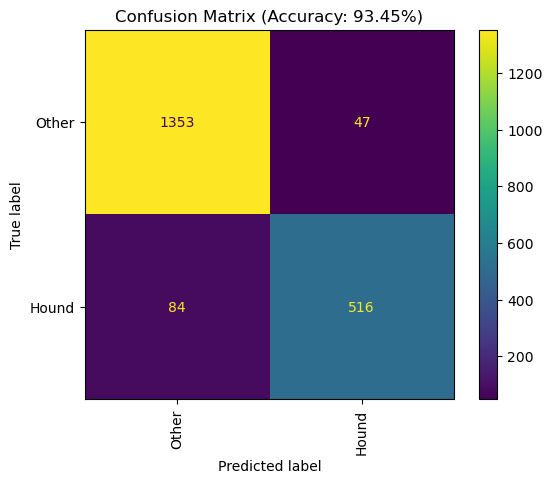

In [5]:
preds  = probs_hound > 0.5
accuracy = (labels_hound == preds).mean()
ConfusionMatrixDisplay.from_predictions(labels_hound, preds, display_labels=['Other', 'Hound'], xticks_rotation='vertical')
plt.title(f'Confusion Matrix (Accuracy: {accuracy*100:.2f}%)')
plt.show()

Can we code it by ourselves? 

In a **binary classification** problem, the **confusion matrix** is defined by the following counts:

|                  | Predicted Negative | Predicted Positive |
|------------------|-------------------|-------------------|
| **Actual Negative** | True Negative (TN) | False Positive (FP) |
| **Actual Positive** | False Negative (FN) | True Positive (TP) |


- TP (True Positive): Model predicts positive, and the true label is positive.
- FP (False Positive): Model predicts positive, but the true label is negative.
- TN (True Negative): Model predicts negative, and the true label is negative.
- FN (False Negative): Model predicts negative, but the true label is positive.

OBS: Sometimes this matrix can look transposed.

**TASK 3:** Compute these counts using only numpy and plot a confusion matrix like sklearn one using matplotlib: 


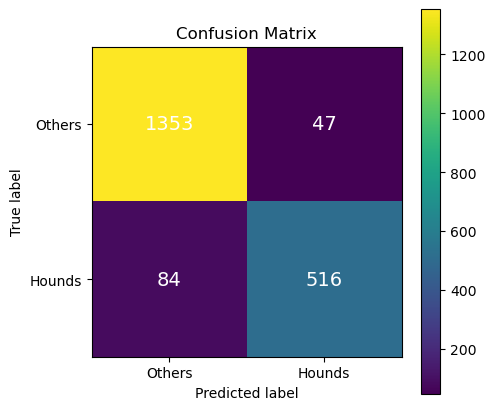

In [18]:
def confusion_matrix_counts(labels, probs, threshold=0.5):
    labels, probs = labels.astype(bool), probs.astype(float)

    # decision threshold
    preds  = probs > threshold

    # confusion matrix counts
    tp = np.logical_and(preds, labels).sum() 
    fp = np.logical_and(preds, ~labels).sum() 
    tn = np.logical_and(~preds, ~labels).sum() 
    fn =  np.logical_and(~preds, labels).sum()

    return tp, fp, tn ,fn


# plot confusion matrix with counts
tp, fp, tn, fn = confusion_matrix_counts(labels_hound, probs_hound, threshold=0.5)
cm_counts = np.array([[tn, fp], [fn, tp]]).astype(np.int32)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_counts, cmap='viridis')

# Add text annotations
for i in range(cm_counts.shape[0]):
    for j in range(cm_counts.shape[1]):
        ax.text(j, i, str(cm_counts[i, j]),
                ha='center', va='center', color='white', fontsize=14)

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Others', 'Hounds'])
ax.set_yticklabels(['Others', 'Hounds'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Optional: colorbar
plt.colorbar(im, ax=ax)
plt.show()


From the confusion matrix, we can compute classification metrics and curves that will help us to evaluate our model:

###  Precision
Precision measures the proportion of correctly predicted positive samples out of all samples predicted as positive.

$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{TP}{PP}
$$

- High precision → very few false positives.  
- Example: Out of all dogs predicted to be hound dogs, how many really are?


### Recall (Sensitivity, True Positive Rate)
Recall measures the proportion of correctly predicted positive samples out of all actual positive samples.

$$
\text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{P}
$$

- High recall → very few false negatives.  
- Example: Out of all dogs that are actually hound dogs, how many did we detect?


###  F-Score (F1-Score)
The F-score is the harmonic mean of precision and recall. It balances the two metrics:

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- High F1 means both precision and recall are reasonably high.  
- Useful when there is **class imbalance**.

Let's compute these metrics for our hound classification problem.

**TASK 4:** From the confusion matrix counts (i.e., tp, fp, tn, fn) computed above, compute precision, recall and f-score. 

In [ ]:
# compute precision, recall, f-score
def compute_metrics(labels, probs, threshold=0.5):
    # get confusion matrix counts
    tp, fp, tn, fn = confusion_matrix_counts(labels, probs, threshold=threshold)
    # metrics equations
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    fscore = (2 * (prec * rec)) / (prec + rec)
    return prec, rec, fscore

# change threshold here
threshold = 0.5
prec, rec, fscore = compute_metrics(labels_hound, probs_hound, threshold=threshold)

print(f"Threshold={threshold:.2f}, precision={prec:.2f}, recall={rec:.2f}, f-score={fscore:.2f}")

Threshold=0.50, precision=0.92, recall=0.86, f-score=0.89


However, this performance is calculated for a threshold of 0.5. You can re-run the code using different thresholds. By setting different thresholds, we obtain different results. Which threshold should we choose, and how can we compare or evaluate performance across all possible thresholds? What happens with precision and recall metrics as we change the threhold?

To answer this question, let's have a look in the distribution of our predictions.

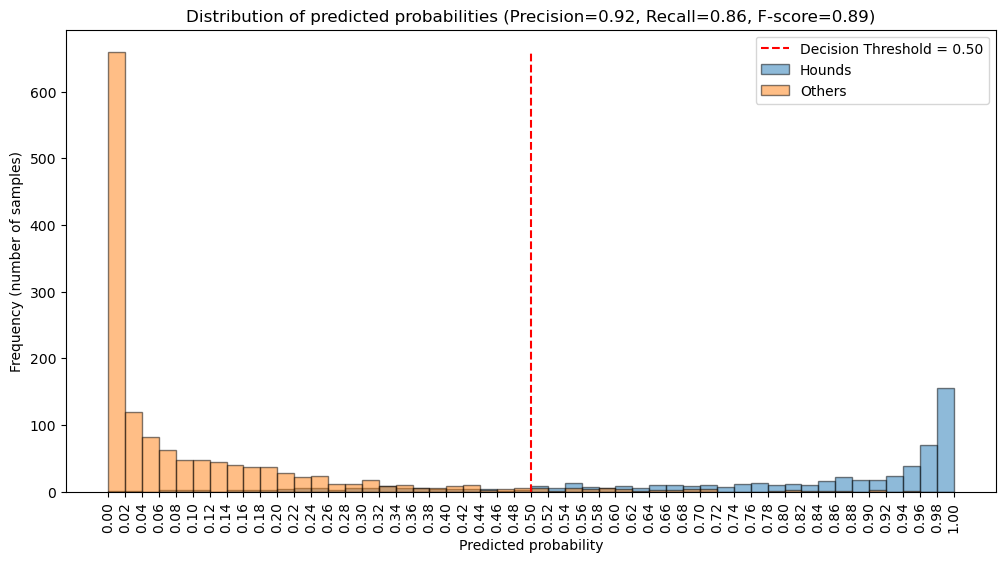

In [38]:
# Create histogram
num_bins = 50  # number of bins (e.g., 0.0–0.1, 0.1–0.2, ..., 0.9–1.0)
threshold = 0.5 # decision threshold
hounds_counts, hounds_bin_edges = np.histogram(probs_hound[labels_hound], bins=num_bins, range=(0, 1))
others_counts, others_bin_edges = np.histogram(probs_hound[~labels_hound], bins=num_bins, range=(0, 1))

# Plot histogram using matplotlib
plt.figure(figsize=(12, 6))
plt.bar(hounds_bin_edges[:-1], hounds_counts, width=hounds_bin_edges[1] - hounds_bin_edges[0], edgecolor='black', align='edge', label='Hounds', alpha=0.5)
plt.bar(others_bin_edges[:-1], others_counts, width=others_bin_edges[1] - others_bin_edges[0], edgecolor='black', align='edge', label='Others', alpha=0.5)
plt.xlabel('Predicted probability')
plt.ylabel('Frequency (number of samples)')
prec, rec, fscore = compute_metrics(labels_hound, probs_hound, threshold=threshold)
plt.vlines(x=threshold, ymin=0, ymax=max(max(hounds_counts), max(others_counts)), colors='red', linestyles='dashed', label=f'Decision Threshold = {threshold:.2f}')
plt.title(f'Distribution of predicted probabilities (Precision={prec:.2f}, Recall={rec:.2f}, F-score={fscore:.2f})')
plt.xticks(np.linspace(0, 1, num_bins + 1), rotation=90)  # ticks at each bin edge
plt.legend()
plt.show()

> **Note:** Selecting a threshold defines how the model decides whether a dog is a hound or not.  

Misclassifications occur in two ways:

- **False positives (FP):** a non-hound dog receives a probability **higher than the threshold** and is incorrectly classified as a hound.  
- **False negatives (FN):** a hound dog receives a probability **lower than the threshold** and is incorrectly classified as not a hound.  

Adjusting the threshold **trades off false positives and false negatives**:

- Moving the threshold to the **left** increases the number of hounds detected but may also increase false positives.  
- Moving the threshold to the **right** reduces false positives but may increase false negatives.  

The choice of threshold depends on the **application** — whether it is more important to avoid false negatives or false positives.


### ROC Curve

But how to see this trade off in terms of metrics? An how to evaluate a model across all threholds? The **ROC (Receiver Operating Characteristic) curve** is a tool to evaluate the performance of a **binary classifier** across **all possible thresholds**.  

- **x-axis:** False Positive Rate (FPR)  (also called 1−Specificity)
$$
\text{FPR} = \frac{FP}{FP + TN} = \frac{FP}{N}
$$  

- **y-axis:** True Positive Rate (TPR) (also named sensitivity)  
$$
\text{TPR} = \text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{P}
$$  

- Each point on the curve corresponds to a different **decision threshold** used to convert probabilities into class labels.  

- The **diagonal line** represents random guessing; points above it indicate better-than-random performance.

- The classifier's performance on the ROC curve is often summarized by a single number: the area under the ROC curve (**AUC-ROC**).

- Sklearn provide functions to compute [ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) curve and [AUC-ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). But, we can also do by ourselves.

**TASK 5:** Complete the code below to plot the ROC curve. Specifically, fill out the loop computing tpr and fpr.


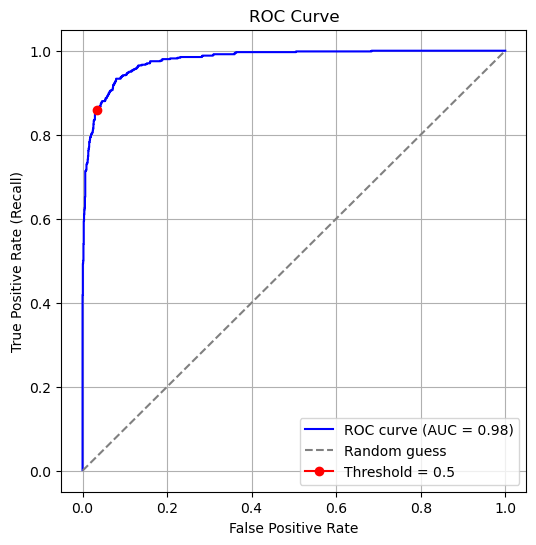

In [43]:
# Sort scores and corresponding true labels descending
desc_order = np.argsort(-probs_hound)
y_true_sorted = labels_hound[desc_order]
y_scores_sorted = probs_hound[desc_order]

# Initialize counts
TP, FP = 0, 0  
P, N = np.sum(labels_hound == 1), np.sum(labels_hound == 0)

tpr_list = []
fpr_list = []

for label in y_true_sorted:
    if label == 1:
        TP += 1
    else:
        FP += 1
    tpr_list.append(TP / P)
    fpr_list.append(FP / N)

# Convert to numpy arrays
tpr = np.array(tpr_list)
fpr = np.array(fpr_list)
auc = np.trapezoid(tpr, fpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
ths=0.5; pred_ths = probs_hound >= ths;
tpr_ths = (pred_ths & labels_hound).sum() / P
fpr_ths = (pred_ths & ~labels_hound).sum() / N
plt.plot(fpr_ths, tpr_ths, marker='o', color='red', label=f'Threshold = {ths}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Likewise, **moving along the ROC curve reflects the trade-off between false positives and false negatives** as the threshold changes.

An ideal classifier would be close to the **top-left corner** of the ROC space (high TPR and low FPR).  
The choice of operating point (threshold) depends on the **application requirements** and the relative cost of false positives versus false negatives.

# 3) Classifier Calibration

Calibration measures how well a classifier's **predicted probabilities** match the **true likelihood of an event**.  

- A perfectly calibrated model outputs probabilities that reflect the actual frequency of positives.  
- Example (binary classification):
  - If the model predicts **0.7** for 100 samples, roughly **70 of them should belong to the positive class**.
  - If it predicts **0.2**, about **20 should be positive**.

WARN: High accuracy does not guarantee well-calibrated probabilities, which can make them unreliable for decision-making, risk assessment, or thresholding.


Let's plot a calibration curve to check our classifier

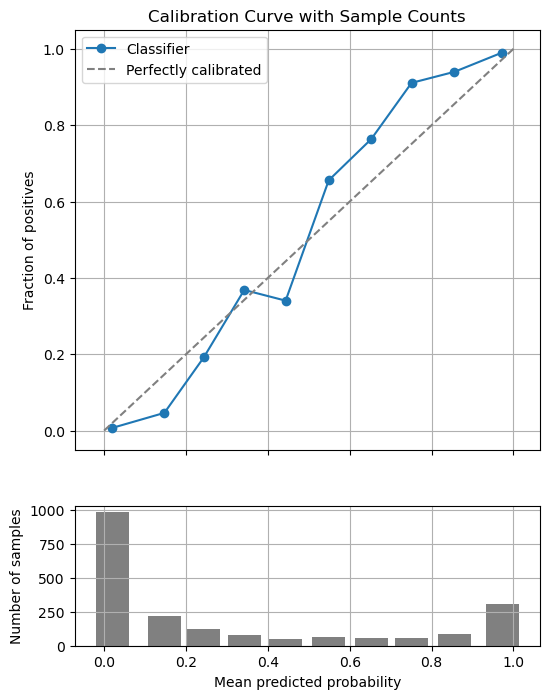

In [44]:
# Number of bins
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

bin_indices = np.digitize(probs_hound, bins) - 1  # get bin index for each probability
bin_true_frac = []
bin_mean_prob = []
bin_counts = []

for i in range(n_bins):
    mask = bin_indices == i
    mask_sum = np.sum(mask)
    bin_counts.append(mask_sum)
    if mask_sum > 0:
        bin_true_frac.append(np.mean(labels_hound[mask]))  # fraction of positives
        bin_mean_prob.append(np.mean(probs_hound[mask]))  # mean predicted probability
    else:
        bin_true_frac.append(np.nan)
        bin_mean_prob.append(np.nan)

# Convert to arrays
bin_true_frac = np.array(bin_true_frac)
bin_mean_prob = np.array(bin_mean_prob)
bin_counts = np.array(bin_counts)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8), sharex=True, gridspec_kw={'height_ratios':[3,1]})

# Top: calibration curve
ax1.plot(bin_mean_prob, bin_true_frac, marker='o', label='Classifier')
ax1.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfectly calibrated')
ax1.set_ylabel('Fraction of positives')
ax1.set_title('Calibration Curve with Sample Counts')
ax1.grid(True)
ax1.legend()

# Bottom: histogram of counts
ax2.bar(bin_mean_prob, bin_counts, width=0.08, color='gray')
ax2.set_xlabel('Mean predicted probability')
ax2.set_ylabel('Number of samples')
ax2.grid(True)

plt.show()

### Overconfident and Underconfident Predictions

- **Overconfident:** Predicted probabilities are **too high** compared to actual outcomes.  
  - Example: The model predicts 0.9, but only 60% of samples are truly positive.  
  - Calibration Curve **below** the diagonal
- **Underconfident:** Predicted probabilities are **too low** compared to actual outcomes.  
  - Example: The model predicts 0.4, but 70% of samples are truly positive.  
  - Calbration Curve **above** the diagonal


# Extending Binary Metrics to Multi-class Classification

So far, we have discussed metrics, ROC curves, and calibration in the context of **binary classification**.  

**Question:**  
How could you adapt these concepts to a **multi-class classification problem**? Consider:

- How would you compute precision, recall, and F1-score when there are more than two classes?  
- How can ROC curves and AUC be extended beyond binary problems?  
- How could you assess and visualize calibration for multiple classes?

Try to think about strategies like **one-vs-rest**, **macro vs. micro averaging**, and grouping classes.  

**Reading:**  
- [scikit-learn: Multiclass classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)  
- [scikit-learn: ROC curves for multiclass](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)  
- [scikit-learn: Calibration of classifiers](https://scikit-learn.org/stable/modules/calibration.html)


# Saliency Maps with Class Activation Mapping (CAM)

Saliency maps help us understand **which regions of an image most influence a model’s prediction**. They are useful for interpreting and debugging CNN-based image classifiers.

Class Activation Mapping (CAM) is a saliency method that uses the **feature maps from the last convolutional layer** of a CNN. These feature maps capture high-level visual patterns (e.g. shapes or object parts). The final classification layer assigns **class-specific weights** to these features, and combining them produces a **class-specific heatmap** showing which regions contributed most to the prediction.

![CAM.png](CAM.png)

The resulting CAM highlights **where the model is “looking”** when predicting a particular class.

CAM is useful for:
- Checking whether the model focuses on the **relevant object** rather than the background.
- Gaining insight into **why a class was predicted**.
- Identifying reliance on **spurious visual cues**.

> **Note:** Standard CAM requires a CNN with a **global average pooling (GAP)** layer followed by a linear classifier. Methods such as **Grad-CAM** relax this requirement and can be applied to a wider range of architectures.


Selected labels: ['basset', 'bloodhound', 'Maltese_dog'] - [11, 14, 6]
Selected indices: [1144, 1447, 664]


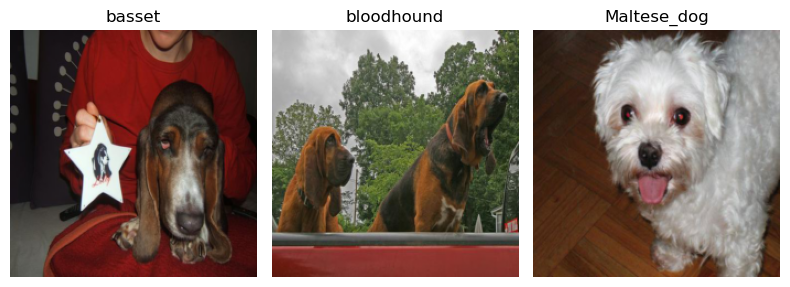

In [45]:
# Selecting a few images
# print(test_dataset.class_to_idx)
selected_label = ['basset', 'bloodhound', 'Maltese_dog']
selected_indices = []
for class_name in selected_label:
    class_idx = test_dataset.class_to_idx[class_name]
    class_samples = [idx for idx, sample in enumerate(test_dataset.samples) if sample[1] == class_idx]
    selected_indices.append(np.random.choice(class_samples, 1).tolist()[0])
print(f"Selected labels: {selected_label} - {[test_dataset.class_to_idx[class_name] for class_name in selected_label]}")
print(f"Selected indices: {selected_indices}")

# Load and display the selected images
fig, axs = plt.subplots(1, 3, figsize=(8, 5))
for i, idx in enumerate(selected_indices):
    x, y = test_dataset[idx]
    x_display = x.cpu().numpy().transpose(1, 2, 0) * imagenet_stds + imagenet_means
    x_display = np.clip(x_display, 0, 1)
    
    axs[i].imshow(x_display)
    axs[i].set_title(f'{test_dataset.classes[y]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


**TASK 6:** Implement the class activation mapping computation in the code below

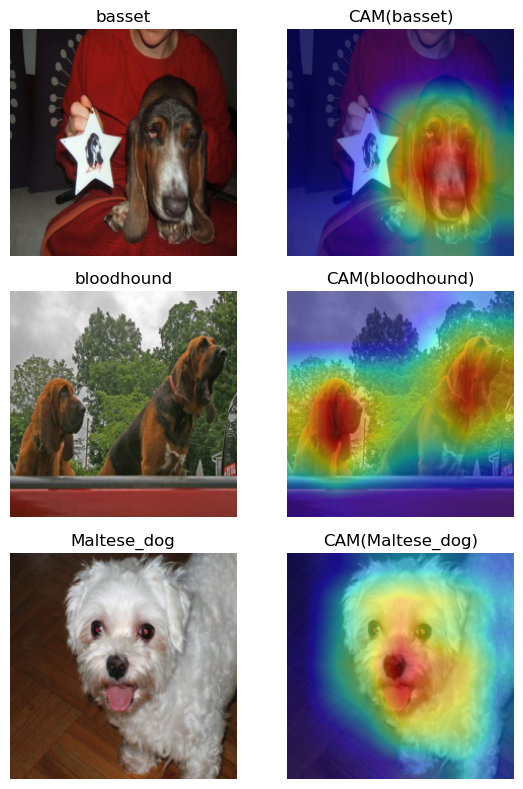

In [47]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

topk = 1
fig, axs = plt.subplots(3,topk+1, figsize=(5*topk+1,8))
resnet.layer4[1].register_forward_hook(get_activation('resnet.layer4.1.conv2'))
resnet.eval()
with torch.no_grad():
    for i, sel_idx in enumerate(selected_indices): 
        x, y = test_dataset[sel_idx]
        x = x.to(device)

        # plot original image
        x_display = x.detach().cpu().numpy().transpose(1, 2, 0) * imagenet_stds + imagenet_means
        x_display = np.clip(x_display, 0, 1)  # Clip to valid range [0, 1]
        axs[i, 0].imshow(x_display)       
        axs[i, 0].set_title(f'{test_dataset.classes[y]}'); axs[i, 0].axis('off');
        
        output = resnet(x.unsqueeze(0))
        topk_preds = torch.topk(output, k=1, dim=1).indices  # top-5 predictions
        conv_feature_map = activation['resnet.layer4.1.conv2'][0].detach()
        
        # compute class activation maps for top-5 predictions
        for j, pred in enumerate(topk_preds[0]):
            fc_weights = resnet.state_dict()['fc.weight'][pred].detach()                
            cam = torch.sum(fc_weights[:,None,None] * conv_feature_map, axis=0)
            cam = cam.clip(min=0); cam = cam / torch.max(cam);
            cam = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(x.shape[1], x.shape[2])   , mode='bilinear', align_corners=False).squeeze().cpu().numpy()
            
            # plot CAM
            axs[i, j+1].imshow(x_display)
            axs[i, j+1].imshow(cam, alpha=0.5, cmap='jet')
            axs[i, j+1].set_title(f'CAM({test_dataset.classes[pred]})')
            axs[i, j+1].axis('off')
        
plt.tight_layout()
plt.show()
   